In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from models.analytical import TrapDiffusion, hadamard, SingleOccupationSingleIsotope, MultiOccupationMultiIsotope

# Standard Trap-Diffusion Model

## Single-Occupation, Single Isotope Model

\begin{aligned}
&\begin{aligned}
\frac{d}{d t}\left(\begin{array}{c}
c_s \\
c_{t, 1} \\
c_{t, 2}
\end{array}\right) & =\left(\begin{array}{l}
1 / c^S \\
1 / c_1^T \\
1 / c_2^T
\end{array}\right) \circ \\
& \left\{\left(\begin{array}{ccc}
-\left(a_{T_1 S} c_1^T \sigma+a_{T_2 S} c_2^T \sigma\right) c^S & a_{S T_1} c_1^T & a_{S T_2} c_2^T \\
a_{T_1 S} c^S c_1^T \sigma & -a_{S T_1} c_1^T & 0 \\
a_{T_2 S} c^S c_2^T \sigma & 0 & -a_{S T_2} c_2^T
\end{array}\right)\left(\begin{array}{c}
c_s \\
c_{t, 1} \\
c_{t, 2}
\end{array}\right)\right.
\end{aligned}\\
&\left.+\left[\left(\begin{array}{c}
c_s \\
c_{t, 1} \\
c_{t, 2}
\end{array}\right) \circ\left(\begin{array}{ccc}
0 & \frac{a_{T_1 s} s^S c_1^T \sigma}{c_{t, 1}^{M a x}} & \frac{a_{T_2 s} s^S c_2^T \sigma}{c_{t, 2}^{M a x}} \\
-\frac{a_{T_1 s} c^s c_1^T \sigma}{c_{t, 1}^{M a x}} & 0 & 0 \\
-\frac{a_{T_2 s} c^T c_2^T \sigma}{c_{t, 2}^{M a x}} & 0 & 0
\end{array}\right)\left(\begin{array}{c}
c_s \\
c_{t, 1} \\
c_{t, 2}
\end{array}\right)\right]\right\}
\end{aligned}

$$
\begin{equation}
\frac{d}{d t} \vec{c}_{s, t}=\left(\frac{1}{\vec{c}^{ S / T}}\right) \circ\left[\underline{\underline{\mathbf{A}}} \vec{c}_{s, t}+\vec{c}_{s, t} \circ \underline{\underline{\mathbf{B}}} \vec{c}_{S, t}\right] .
\end{equation}
$$

$$
\begin{equation}
\underline{\underline{\mathbf{A}}}=\underline{\underline{\tilde{A}}} \underline{\underline{\mathbf{C}}}=\left(\begin{array}{ccc}
-\left(a_{T_1 S} c_1^T \sigma+a_{T_2 S} c_2^T \sigma\right) & a_{S T_1} & a_{S T_2} \\
a_{T_1 S} c_1^T \sigma & -a_{S T_1} & 0 \\
a_{T_2} s c_2^T \sigma & 0 & -a_{S T_2}
\end{array}\right)\left(\begin{array}{ccc}
c^S & 0 & 0 \\
0 & c_1^T & 0 \\
0 & 0 & c_2^T
\end{array}\right)
\end{equation}
$$

- $c_{t,i}$ : concentration of hydrogen trapped in trap of type i
- $c_j^T$ : concentration of traps of type j
- $c_{s}$ : concentration of solute hydrogen in non-trap (solute) sites
- $c^S$ : concentration of solute sites
- $a_{i\leftarrow j}$ : transition rate from j to i, typically in matrix notation in row i and columnn j
- $c_{t,i}^{Max} $ : the upper limit (maximum) of the hydrogen concentration which can be trapped in a trap of type i (capacity limit of trap)
- $\sigma$ : capture cross-section of a trap-site

## TODO

solute in steady state auf 0
-> outflow aus den traps

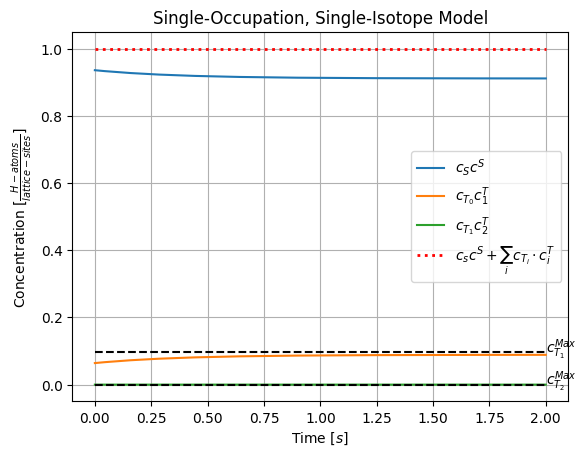

In [2]:
np.random.seed(1)
s = SingleOccupationSingleIsotope(2)
s.plot()

## Single-Occupation, Multiple Isotope Model

# Mulit-Occupation, Single Isotope Model

In [15]:
import numpy as np
from scipy.integrate import solve_ivp
from functools import partial
from models.analytical import hadamard
import matplotlib.pyplot as plt

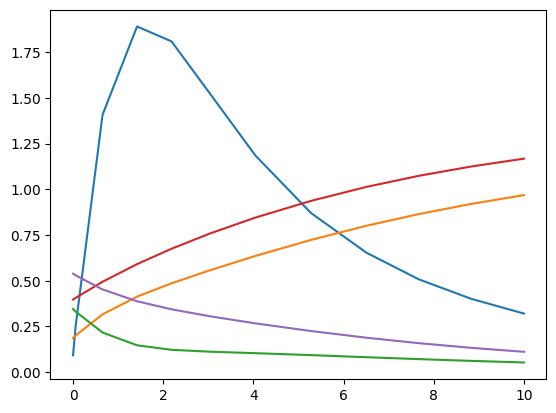

In [18]:
r = partial(np.random.uniform, 0, 1)
np.random.seed(1)
gamma = 1
sigma = 1
T_to_S = np.random.uniform(0,1,4)
T_to_S[0] = 0
cS = r()

c0 = np.random.uniform(0,1,5) # = [c_S, c^T_0, c^T_1, c^T_2, c^T_3], # now trap concentrations change

E = np.identity(5)
E[0,0] = 0
E[0,1:] = -np.arange(0,4) / cS

A = np.zeros((5,5))
A[1,2] = T_to_S[1] # T1 to S
A[2,2] = - T_to_S[1] # - T1 to S
A[2,3] = T_to_S[2] # T2 to S
A[3,3] = - T_to_S[2] # - T2 to S
A[3,4] = T_to_S[3] # T3 to S
A[4,4] = - T_to_S[3] # - T3 to S

H = np.zeros((5,5))
H[1,1] = -1
H[2,2] = -1
H[3,3] = -1
H[2,1] = 1
H[3,2] = 1
H[4,3] = 1

g = gamma * T_to_S * sigma * cS
M = np.zeros((5,5))
M[1:,0] = g

def rhs(t,c):
    return E @ (A@c + hadamard(H@c, M@c))

def jac(t,c):
    return E@(A + hadamard(H,M@c) + hadamard(H@c, M))

sol = solve_ivp(rhs, (0,10), c0)
plt.plot(sol.t, sol.y.T)
plt.show()

# Multi-Occupation, Multiple Isotope Model

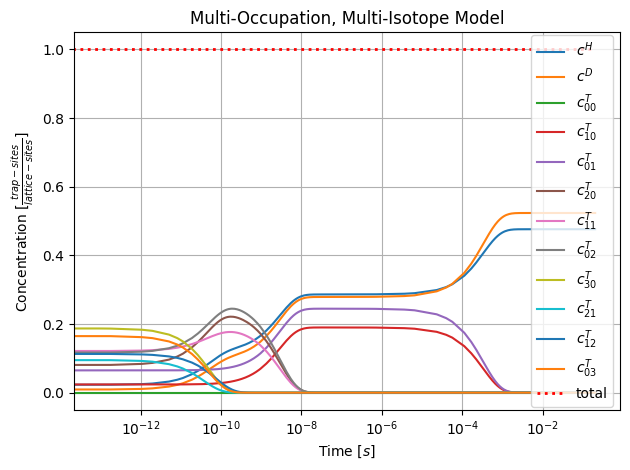

In [27]:
m = MultiOccupationMultiIsotope()
m.plot()